### 下载数据

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml/raw/master/datasets/housing"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
#     urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

### 加载数据

In [2]:
import pandas as pd

# 返回一个Pandas.DataFrame 对象
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
# 查看数据前五行信息
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

### 数据信息

In [3]:
# 快速查看数据描述，总行数、每个属性的类型和非空值的数量
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# value_counts()查看该项中有哪些类别，每个类别数量
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
# describe()方法展示了数值属性的概括
# 空值被忽略了
# 信息包括数量、均值、标准差、最小值、25%分位数、最大值
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

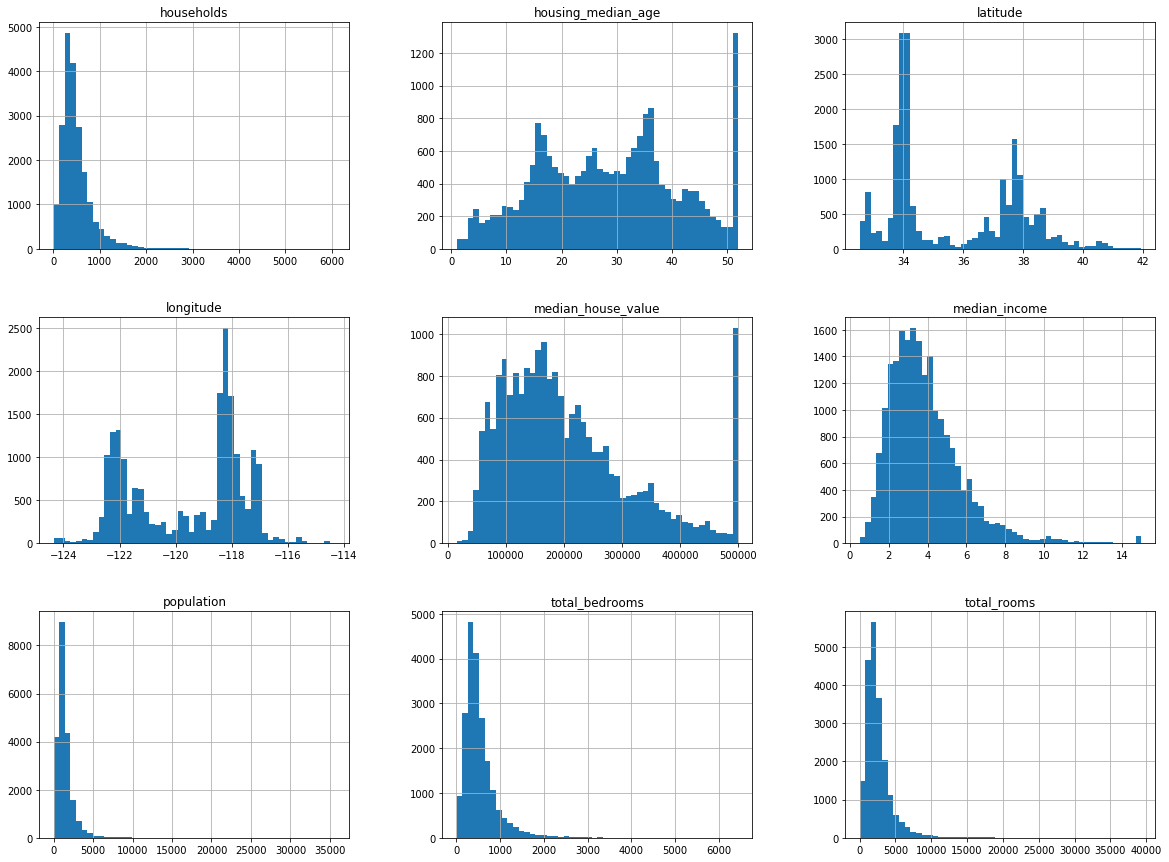

In [6]:
# 对属性进行柱状图分析
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### 分离数据构造训练、测试数据

In [7]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), ':', len(test_set))

16512 : 4128


In [8]:
# 虽然设置随机种子，但在更新数据集之后依然不能保证测试集相同，使用唯一id构建hash表
import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [9]:
# 索引做id
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
print(len(train_set), ':', len(test_set))

16362 : 4278


In [10]:
# 经纬度做id
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')
print(len(train_set), ':', len(test_set))

16267 : 4373


In [11]:
# sklearn自带的切分数据
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), ':', len(test_set))

16512 : 4128


In [12]:
# 考虑属性，进行分层切分，根据收入进行，
# 根据收入进行分层ceil()舍入取整数
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
# 将收入分为5类
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

housing['income_cat'].head(20)

0     5.0
1     5.0
2     5.0
3     4.0
4     3.0
5     3.0
6     3.0
7     3.0
8     2.0
9     3.0
10    3.0
11    3.0
12    3.0
13    2.0
14    2.0
15    2.0
16    2.0
17    2.0
18    2.0
19    2.0
Name: income_cat, dtype: float64

In [13]:
# 调用sklearn 中自带函数进行分层切分（df.loc(index)，根据index进行切片）
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print(len(strat_train_set), ':', len(strat_test_set))

16512 : 4128


In [14]:
# 分层切分之后对比一下原数据、分层切分、随机切分的分布
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1.0  0.039826    0.039729  0.040213      0.973236      -0.243309
2.0  0.318847    0.318798  0.324370      1.732260      -0.015195
3.0  0.350581    0.350533  0.358527      2.266446      -0.013820
4.0  0.176308    0.176357  0.167393     -5.056334       0.027480
5.0  0.114438    0.114583  0.109496     -4.318374       0.127011

In [15]:
# 从数据中删除income_cat使数据恢复
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

### 数据探索和可视化、发现规律

In [16]:
# 创建数据副本，以免损伤训练集
housing = strat_test_set.copy()

##### 地理数据可视化

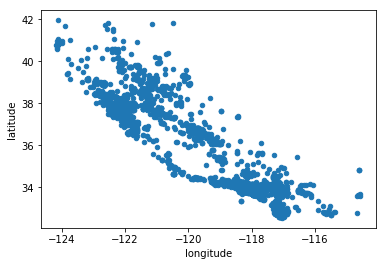

In [17]:
# 根据经纬度进行数据可视化
housing.plot(kind='scatter', x='longitude', y='latitude')

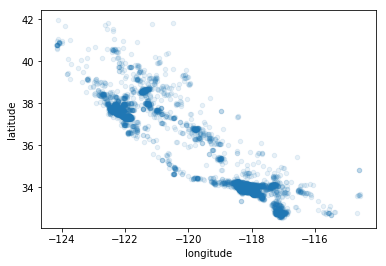

In [18]:
# 根据经纬度进行数据可视化
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

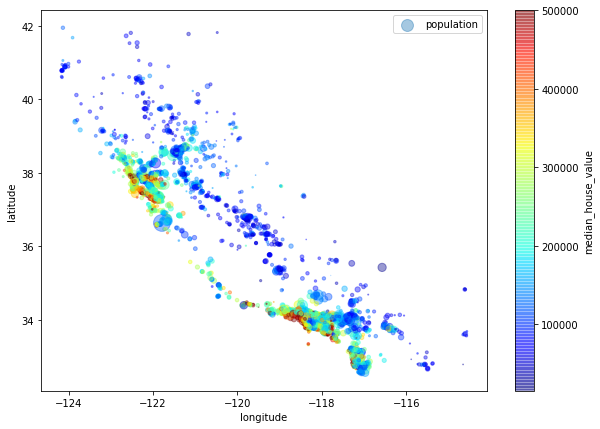

In [19]:
# 查看房价与经纬度、人口的关系
# 圆圈半径表示人口(s)，颜色代表房价(c)，使用预先定义的jet的颜色图(cmp)，从蓝色(低价)到红色(高价)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"] / 100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

### 查找关联

In [20]:
# corr()计算每对属性间的标准相关系数（皮尔逊相关系数）只能测量线性关系，非线性关系忽略
corr_matrix = housing.corr()
# 查看每个属性和房价中位数的关联度，越接近1正相关，接近-1负相关，接近0没有线性相关
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

另一种检测相关性系数的方法是Pandas中的`scatter_matrix()`函数，画出每个数值属性对每个其它数值属性的图，现在11个数值属性，可以得到`9*9=81`张图，只关注几个和房价中位数有关的属性。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000282194095F8>,
      dtype=object)

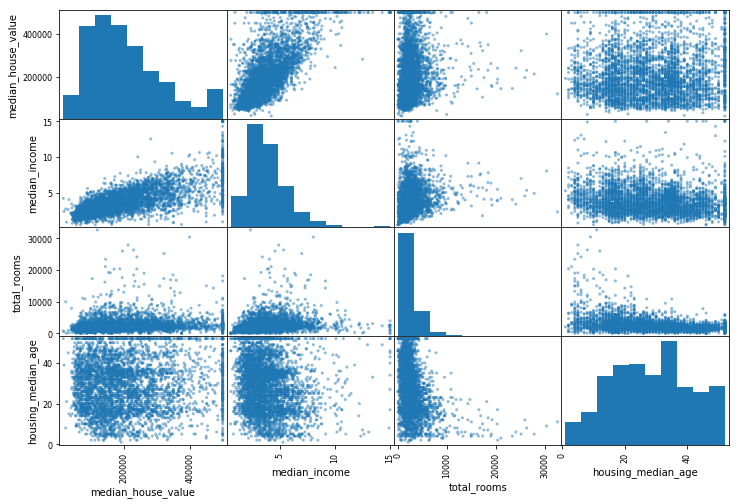

In [21]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

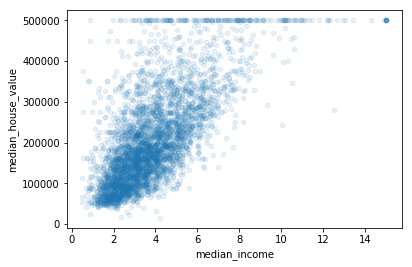

In [22]:
# 最有关系的是收入，放大收入
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

### 属性组合实验

给算法准备数据之前，需要进行多种属性组合；如：不知道街区有多少户，总房间就没什么用，真正需要知道的是每户有几个房间；总卧室也不重要，可能需要将其与房间数进行比较；每户的人口数也需要进行属性组合。

In [23]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [24]:
# 查看此时的相关矩阵
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691831
rooms_per_household         0.192575
total_rooms                 0.131435
housing_median_age          0.071357
households                  0.071242
total_bedrooms              0.057568
population                 -0.016033
longitude                  -0.039987
population_per_household   -0.135142
latitude                   -0.150124
bedrooms_per_room          -0.240362
Name: median_house_value, dtype: float64

## 为算法准备数据

In [34]:
# 重新复制训练集，将数据与标签分开
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### 数据清洗
#### 缺失值处理
> 1. 去掉对应的样本
> 2. 去掉含有缺失值属性
> 3. 进行赋值填充(0、中位数、平均值等等)

In [33]:
housing.dropna(subset=['total_bedrooms']) # 1
housing.drop('total_bedrooms', axis=1)# 2
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median) # 3 中位数填充缺失值


使用scikit-learn中的imputer处理缺失值

In [36]:
# 创建一个imputer实例，指定使用某属性的中位数来替换该属性的所有缺失值
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
# 因为中位数只有数值属性才能计算，需要创建一份不包含文本属性ocean_proximity的数据副本
housing_num = housing.drop('ocean_proximity', axis=1)
# 使用fit()方法将imputer实例拟合到训练集
imputer.fit(housing_num)
# 训练得到中位数存储在imputer.statistics_中
imputer.statistics_



C:\Application\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
# 使用训练过的imputer对训练集进行转换
X = imputer.transform(housing_num) #这是一个包含转换后特征的普通Numpy数组，转为Pandas的DataFrame

In [38]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

#### 处理文本和类别属性
将文本标签转换为数字，使用scikti-learn提供的转换器LabelEncoder

In [39]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

使用`LabelEncoder`转换器转换文本特征的方式是错误的，该转换器只能用来转换标签，此处使用`LabelEncoder`没有出错是因为该数据只有一列文本特征值，如果有多列就会出错。应该使用`factorize()`进行操作.

In [40]:
housing_cat_encoded, housing_cat_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [41]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

因为算法会认为临近的值比疏远的值要更相似。显然这种是不对的(0和4比0和1更相似)。给每个分类建立一个二元属性：当分类为`<1H OCEAN`，该属性为1(否则为0)，进行独热编码。使用`OneHotEncoder`,用于将整数分类值转变为独热向量，此时`fit_transform()`用于2D数组，而`housing_cat_encoded`是一个1D数组，需要变形。

In [42]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

C:\Application\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

输出是一个`SciPy`稀疏矩阵，而不是Numpy数组，如果有数千个分类时，经过独热编码，得到一个数千列的矩阵，每行只有一个1，其余都是0.稀疏矩阵只存储非零元素位置，可以向一个2D数组那样进行使用，也可以使用`toarray()`方法转变为一个(密集的)Numpy数组。

In [43]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

使用类`LabelBinarizer`，我们可以用一步执行这两个转换(从文本分类到整数分类，再从整数分类到独热向量)

In [48]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [49]:
# 返回的数组为密集型Numpy数组，可以向构造器中传递 sparse_output=true，可以得到稀疏矩阵
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

`LabelBinarizer`只能进行标签列的转换，可以使用`CategoricalEncoder`类

#### 自定义转换器
需要创建一个类并执行三个方法:fit()、tranform()、fit_tranform();
通过添加`TransformerMixin`基类很容易得到最后一个
通过添加`BaseEstimator`基类(且构造器中避免使用* arg和** kargs)，就能得到两个额外的方法(get_params()和set_params()),可以进行超参数自动微调

In [57]:
# 一个朝参数add_bedrooms_per_room
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6


class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### 特征缩放
归一化：减去最小值除以最大值与最小值的差值（MinMaxScalar实现功能，有一个超参数`feature_range`,设置需要改变的范围）
标准化：首先减去平均值（标准化后的平均值总是0），然后除以方差，使得到的分布据偶单位方差（`StandardScaler`进行标准化）。


### 转换流水线
许多数据转换步骤需要按照一定顺序执行。scikit-Learn提供了`Pipeline`(构造器需要一个定义步骤的名字/估计器对的列表，除了最后一个估计器，其余都需要是转换器，即都要有`fit_transform()`方法),来进行一系列的转换，调用流水线的`fit()`方法就会对所有转换器顺序调用`fit_transform()`方法，将每次调用的输出作为参数传递给下一个调用，一直到最后一个估计器，只执行`fit()`方法。下面是一个数值属性的小流水线：

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_popeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributeAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_popeline.fit_transform(housing_num)


C:\Application\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


流水线暴露相同的方法作为最终的估计器，上述例子中，最后的估计器是`StandardScalar`,他是一个转换器，因此流水线有一个`transform()`方法，可以顺序对数据做所有转换(它还有一个`fit_transform()`方法，不必先调用`fit`,在调用`transform`)。
由于Scikit-Learn没有处理Pandas数据的DataFrame，因此需要自己自定义一个如下：

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

上面的pineline只是用于处理实数特征的，对于处理类别特征的还有另一个Pineline，这就可以使用FearureUnion类来结合多个pineline，调用它的`transform`时每个转换器的`transform`都会被并行执行(调用它的fit会调用每个转换器的fit)，多个Pineline可以并行处理，最后将结果拼接在一起输出。

完整数值、类别处理流水线如下：

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
class LabelBinarizer_new(TransformerMixin, BaseEstimator):
    def fit(self, X, y = 0):
        self.encoder = None
        return self
    def transform(self, X, y = 0):
        if(self.encoder is None):
            print("Initializing encoder")
            self.encoder = LabelBinarizer();
            result = self.encoder.fit_transform(X)
        else:
            result = self.encoder.transform(X)
        return result

from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('scelector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributeAdder(add_bedrooms_per_room=False)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('scelector', DataFrameSelector(cat_attribs)),
#     ('label_binarizer', LabelBinarizer()),
    ('label_binarizer', LabelBinarizer_new()),
    
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

Initializing encoder


C:\Application\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])